In [1]:
import numpy as np
import pandas as pd
import pdb

In [2]:
df1 = pd.read_csv('./data/kospi200.csv',index_col=0,
                 header=0,encoding='cp949',sep=',')
pd.set_option('display.max_row',None)
pd.set_option('display.max_column',None)

print(df1.shape)
df1.head(5)

(426, 5)


,시가,고가,저가,현재가,거래량
일자,,,,,
2020-01-31,290.24,291.47,284.53,284.53,"101,455"
2020-01-30,293.27,294.11,287.09,288.37,"101,535"
2020-01-29,294.38,295.67,292.45,293.98,"85,731"
2020-01-28,294.98,296.30,291.30,292.77,"130,172"
2020-01-23,303.77,304.72,301.71,302.33,"86,908"


In [3]:
df2 = pd.read_csv('./data/samsung.csv',index_col=0,
                 header=0,encoding='cp949',sep=',')
print(df2.shape)
df2.head(5)

(426, 5)


,시가,고가,저가,종가,거래량
일자,,,,,
2020-01-31,"57,800","58,400","56,400","56,400","19,749,457"
2020-01-30,"58,800","58,800","56,800","57,200","20,821,939"
2020-01-29,"59,100","59,700","58,800","59,100","16,446,102"
2020-01-28,"59,400","59,400","58,300","58,800","23,664,541"
2020-01-23,"61,800","61,800","60,700","60,800","14,916,555"


In [4]:
# change string format to numeric format
for i in range(len(df1.index)):
    df1.iloc[i,4] = int(df1.iloc[i,4].replace(',',''))
for i in range(len(df2.index)):
    for j in range(len(df2.iloc[i])):
        df2.iloc[i,j] = int(df2.iloc[i,j].replace(',',''))

In [5]:
# sort by datetime
df1 = df1.sort_values(['일자'],ascending=[True])
df2 = df2.sort_values(['일자'],ascending=[True])

In [6]:
# pandas to numpy
df1 = df1.values
df2 = df2.values

# save numpy objects
np.save('./data/kospi200.npy',arr=df1)
np.save('./data/samsung.npy',arr=df2)

In [92]:
kospi200 = np.load('./data/kospi200.npy',allow_pickle=True)
samsung = np.load('./data/samsung.npy',allow_pickle=True)
print(kospi200.shape)
print(samsung.shape)

(426, 5)
(426, 5)


# Split as window size

In [93]:
# split data to window
def split_xy5(dataset, time_steps, y_column):
    x,y = list(), list()
    for i in range(len(dataset)):
        x_end_number = i + time_steps
        y_end_number = x_end_number + y_column
        if y_end_number > len(dataset):
            break
        tmp_x = dataset[i:x_end_number, :]
        tmp_y = dataset[x_end_number:y_end_number,3] # just a end_price
        x.append(tmp_x)
        y.append(tmp_y)
    return np.array(x), np.array(y)

In [94]:
x,y = split_xy5(samsung,5,1)
print(x[0,:],"\n",y[0])
print(x.shape) # shape : batch_size , time_steps(window_size), columns(features)
print(y.shape)

[[53000 53900 51800 51900 39565391]
 [52600 53200 51900 52600 23104720]
 [52600 52800 50900 50900 16128305]
 [51700 51700 50600 51600 13905263]
 [52000 52200 51200 51300 10314997]] 
 [50100]
(421, 5, 5)
(421, 1)


# Train-Test split

In [95]:
# split as train, test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
x,y,random_state=1, test_size=0.3)
print(x_train.shape,
     x_test.shape,
     y_train.shape,
     y_test.shape,
     sep='\n')

(294, 5, 5)
(127, 5, 5)
(294, 1)
(127, 1)


# Preprocessing

In [96]:
# reshape datasets to 1 dimension or preprocessing
x_train = np.reshape(x_train,
                    (x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
x_test = np.reshape(x_test,
                   (x_test.shape[0],x_test.shape[1]*x_test.shape[2]))
print(x_train.shape,
     x_test.shape,
     sep='\n')

(294, 25)
(127, 25)


In [97]:
x_train[0,:] # flattened

array([51200, 51400, 50200, 50300, 11179334, 50900, 51300, 50400, 50400,
       18877252, 49800, 50300, 49500, 49900, 12059812, 49600, 49850,
       49000, 49450, 13246549, 50200, 50400, 49500, 49500, 10449715],
      dtype=object)

In [98]:
# preprocessing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
print(x_train_scaled[0,:])

[ 1.13392563  1.07633086  1.02393741  0.93187013 -0.028819    1.05994459
  1.04756614  1.06686328  0.94933344  1.53138774  0.79093879  0.80213886
  0.84540479  0.81507608  0.10811605  0.73712199  0.68893234  0.71073997
  0.69657856  0.37360361  0.85647275  0.80021877  0.80910994  0.69442952
 -0.16973555]


# DNN(FFNN)

In [99]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [100]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel,self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(25,64,bias=True),
            nn.ReLU(),
            nn.Linear(64,32,bias=True),
            nn.ReLU(),
            nn.Linear(32,32,bias=True),
            nn.ReLU(),
            nn.Linear(32,32,bias=True),
            nn.ReLU(),
            nn.Linear(32,1,bias=True)
        )
    def forward(self,x):
        out = self.seq(x)
        return out

In [101]:
model = DNNModel()

In [102]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3,verbose=True)

In [103]:
import copy
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

In [104]:
EPOCHS = 100
patience = 20
train_val_ratio = 0.2
batch_size = 1
best_loss = float('inf')
epoch_counter = 0
done = False
es = EarlyStopping(patience=patience)
tr_losses_for_plot,val_losses_for_plot = [],[]

# prepare DataLoader
x_train_scaled_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.astype(np.float32), dtype=torch.float32)
x_tr, x_val, y_tr, y_val = train_test_split(
    x_train_scaled_tensor, y_train_tensor,test_size=0.2)

train_loader = DataLoader(TensorDataset(x_tr,y_tr),batch_size=batch_size,
                         shuffle=True)
val_loader = DataLoader(TensorDataset(x_val,y_val),batch_size=batch_size,
                       shuffle=False)

while not done and epoch_counter<EPOCHS:
    epoch_counter += 1
    # train mode
    model.train()
    train_losses = []
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    tr_losses_for_plot.append(train_loss)
        
    # validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            output = model(x_batch)
            loss = criterion(output, y_batch)
            val_losses.append(loss.item())
    val_loss = np.mean(val_losses)
    val_losses_for_plot.append(train_loss)
    scheduler.step(val_loss)
    
    if es(model, val_loss):
        done = True
    
    print(f"Epoch {epoch_counter}/{EPOCHS}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        

Epoch 1/100, Train Loss: 1965548849.7532, Validation Loss: 1077957230.2034
Epoch 2/100, Train Loss: 823064374.0883, Validation Loss: 626128206.0953
Epoch 3/100, Train Loss: 667894129.6258, Validation Loss: 535575886.1525
Epoch 4/100, Train Loss: 563560355.2816, Validation Loss: 432446887.6875
Epoch 5/100, Train Loss: 458395876.5191, Validation Loss: 342241305.4153
Epoch 6/100, Train Loss: 347927935.1405, Validation Loss: 229507832.4269
Epoch 7/100, Train Loss: 255902090.9601, Validation Loss: 177100760.6290
Epoch 8/100, Train Loss: 176568270.3233, Validation Loss: 133609923.8731
Epoch 9/100, Train Loss: 115896648.3318, Validation Loss: 69732792.0340
Epoch 10/100, Train Loss: 61395761.3179, Validation Loss: 33241286.0212
Epoch 11/100, Train Loss: 27966369.8285, Validation Loss: 16433241.7115
Epoch 12/100, Train Loss: 13383708.3238, Validation Loss: 7892062.0305
Epoch 13/100, Train Loss: 6845397.0311, Validation Loss: 4703981.3366
Epoch 14/100, Train Loss: 4024249.9688, Validation Loss: 

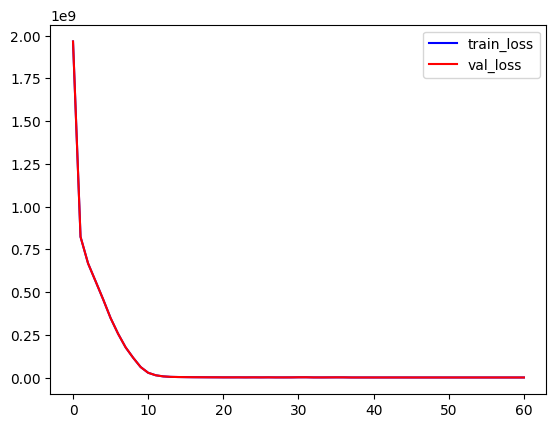

In [105]:
import matplotlib.pyplot as plt
plt.plot(range(len(tr_losses_for_plot)),tr_losses_for_plot,color='blue',label='train_loss')
plt.plot(range(len(val_losses_for_plot)),val_losses_for_plot,color='red',label='val_loss')
plt.legend()
plt.show()

In [106]:
from sklearn.metrics import mean_squared_error
# evaluation
model.eval()
with torch.no_grad():
    x_test_scaled_tensor = torch.tensor(x_test_scaled,dtype=torch.float32)
    pred = model(x_test_scaled_tensor)
    pred = pred.detach().numpy()
mse = mean_squared_error(y_test, pred)

In [107]:
def error_ratio(pred, true):
    return np.mean(np.abs(pred-true)/true)

print(error_ratio(pred, y_test)) # 평균적으로 1.9%의 오차율를 보인다.

0.016987154008013972


In [108]:
for i in range(5):
    print(f'종가 : {y_test[i]} / 예측가 : {pred[i]} / 오차율 : {np.abs(y_test[i]-pred[i])/y_test[i]}')

종가 : [52200] / 예측가 : [52959.344] / 오차율 : [0.014546815134099616]
종가 : [41450] / 예측가 : [40917.438] / 오차율 : [0.012848311218335344]
종가 : [49650] / 예측가 : [58524.402] / 오차율 : [0.17873922142497484]
종가 : [44800] / 예측가 : [46000.137] / 오차율 : [0.026788766043526785]
종가 : [49500] / 예측가 : [49211.105] / 오차율 : [0.005836253156565657]


In [109]:
len(np.reshape(y_test,(-1)))

127

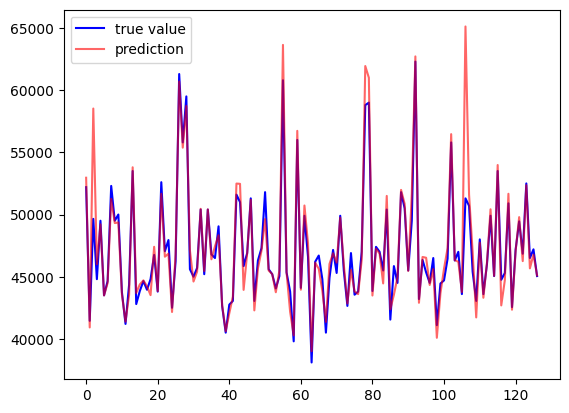

In [112]:
r = len(np.reshape(y_test,(-1)))
plt.plot(list(range(r)),np.reshape(y_test,(-1)), color='blue', label='true value')
plt.plot(list(range(r)),np.reshape(pred,(-1)), color='red',alpha=0.6, label='prediction')
plt.legend()
plt.show()

# LSTM

In [143]:
kospi200 = np.load('./data/kospi200.npy',allow_pickle=True)
samsung = np.load('./data/samsung.npy',allow_pickle=True)

In [144]:
def split_xy_window(dataset, time_steps, y_column):
    x,y = [],[]
    for i in range(len(dataset)):
        x_end_number = i + time_steps
        y_end_number = x_end_number + y_column
        
        if y_end_number>len(dataset):
            break
        tmp_x = dataset[i:x_end_number,:]
        tmp_y = dataset[x_end_number:y_end_number,3]
        x.append(tmp_x)
        y.append(tmp_y)
    return np.array(x), np.array(y)

In [145]:
# time step = 5
x,y = split_xy_window(samsung,5,1)
print(x.shape,y.shape,sep='\n')

(421, 5, 5)
(421, 1)


In [146]:
# train-test split
x_train, x_test, y_train, y_test = train_test_split(
    x,y,random_state=1, test_size=0.3)
# reshape datasets to 1 dimension or preprocessing
x_train = np.reshape(x_train,
                    (x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
x_test = np.reshape(x_test,
                   (x_test.shape[0],x_test.shape[1]*x_test.shape[2]))
print(x_train.shape,
     x_test.shape,
     sep='\n')
# preprocessing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
print(x_train_scaled[0,:])

(294, 25)
(127, 25)
[ 1.13392563  1.07633086  1.02393741  0.93187013 -0.028819    1.05994459
  1.04756614  1.06686328  0.94933344  1.53138774  0.79093879  0.80213886
  0.84540479  0.81507608  0.10811605  0.73712199  0.68893234  0.71073997
  0.69657856  0.37360361  0.85647275  0.80021877  0.80910994  0.69442952
 -0.16973555]


In [147]:
# reshape to (None,5,5)
x_train = np.reshape(x_train_scaled,
                    (x_train_scaled.shape[0],5,5))
x_test = np.reshape(x_test_scaled,
                    (x_test_scaled.shape[0],5,5))
print(x_train.shape, x_test.shape, sep='\n') 
# batch_size, time_step, features

(294, 5, 5)
(127, 5, 5)


In [148]:
class LSTMModel(nn.Module):
    def __init__(self,input_dim):
        super(LSTMModel,self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_size=64, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.seq = nn.Sequential(nn.Linear(64,32),
                                nn.ReLU(),
                                nn.Linear(32,32),
                                nn.ReLU(),
                                nn.Linear(32,32),
                                nn.ReLU(),
                                nn.Linear(32,32),
                                nn.ReLU(),
                                nn.Linear(32,1)
                                )
        
    def forward(self,x):
        x,_ = self.lstm(x)
#         print('output of lstm :',x.size()) # torch.Size([1, 5, 64])
        x = self.dropout(x[:,-1,:])
#         print('from lstm to linear :',x.size()) # torch.Size([1, 64])
        x = self.seq(x)
        return x
    
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [149]:
model = LSTMModel(x_train.shape[2])

In [150]:
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=20,verbose=True)

In [151]:
# to DataLoader
x_tr, x_val, y_tr, y_val = train_test_split(x_train,y_train,
                                           random_state=1,test_size=0.2)

# to tensor
x_tr_tensor = torch.tensor(x_tr.astype(np.float32),dtype=torch.float32)
x_val_tensor = torch.tensor(x_val.astype(np.float32),dtype=torch.float32)
y_tr_tensor = torch.tensor(y_tr.astype(np.float32),dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.astype(np.float32),dtype=torch.float32)

# to DataLoader
batch_size = 1
train_loader = DataLoader(TensorDataset(x_tr_tensor,y_tr_tensor),
                         batch_size=batch_size,shuffle=True)
val_loader = DataLoader(TensorDataset(x_val_tensor,y_val_tensor),
                       batch_size=batch_size,shuffle=False)

In [152]:
EPOCHS = 100
epoch_counter = 0
patience = 20
best_loss = float('inf')
done = False
es = EarlyStopping(patience=patience)
tr_losses_fp, val_losses_fp = [],[]

while not done and epoch_counter<EPOCHS:
    epoch_counter+=1
    
    # train
    model.train()
    train_losses = []
    for x_batch,y_batch in train_loader:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output,y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    tr_losses_fp.append(train_loss)
    
    # validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            output = model(x_batch)
            loss = criterion(output, y_batch)
            val_losses.append(loss.item())
    val_loss = np.mean(val_losses)
    val_losses_fp.append(val_loss)
    scheduler.step(val_loss)
    
    if es(model, val_loss):
        done = True
    
    print(f"Epoch {epoch_counter}/{EPOCHS}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/100, Train Loss: 37157.5112, Validation Loss: 3277.9074
Epoch 2/100, Train Loss: 4775.3141, Validation Loss: 3067.4564
Epoch 3/100, Train Loss: 3880.4449, Validation Loss: 1884.0515
Epoch 4/100, Train Loss: 3111.7374, Validation Loss: 2741.7582
Epoch 5/100, Train Loss: 2690.8054, Validation Loss: 813.0210
Epoch 6/100, Train Loss: 2587.2501, Validation Loss: 756.5896
Epoch 7/100, Train Loss: 2875.9758, Validation Loss: 1477.8898
Epoch 8/100, Train Loss: 2694.6962, Validation Loss: 1030.9973
Epoch 9/100, Train Loss: 2699.0918, Validation Loss: 1630.9487
Epoch 10/100, Train Loss: 2691.1130, Validation Loss: 1257.7219
Epoch 11/100, Train Loss: 2689.2323, Validation Loss: 1147.0461
Epoch 12/100, Train Loss: 2491.3074, Validation Loss: 1532.1970
Epoch 13/100, Train Loss: 2837.9302, Validation Loss: 939.4378
Epoch 14/100, Train Loss: 2858.8118, Validation Loss: 915.3191
Epoch 15/100, Train Loss: 2719.3166, Validation Loss: 965.9077
Epoch 16/100, Train Loss: 2693.2416, Validation Loss:

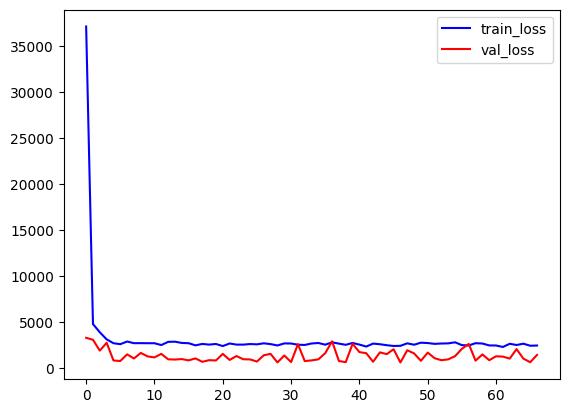

In [153]:
import matplotlib.pyplot as plt
plt.plot(range(len(tr_losses_fp)),tr_losses_fp,color='blue',label='train_loss')
plt.plot(range(len(val_losses_fp)),val_losses_fp,color='red',label='val_loss')
plt.legend()
plt.show()

In [155]:
# evaluation
model.eval()
with torch.no_grad():
    x_test_tensor = torch.tensor(x_test.astype(np.float32),dtype=torch.float32)
    pred = model(x_test_tensor)

In [160]:
pred_np = pred.detach().numpy()

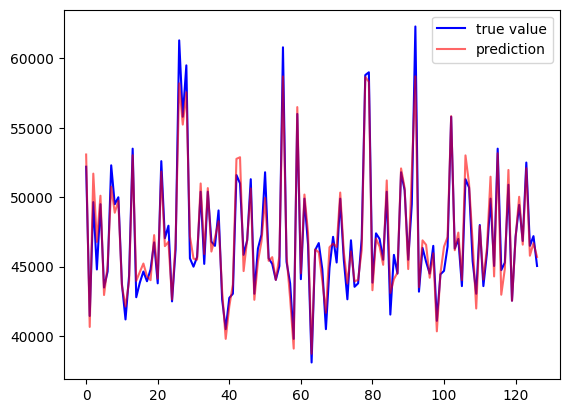

In [162]:
r = len(np.reshape(y_test,(-1)))
plt.plot(list(range(r)),np.reshape(y_test,(-1)), color='blue', label='true value')
plt.plot(list(range(r)),np.reshape(pred_np,(-1)), color='red',alpha=0.6, label='prediction')
plt.legend()
plt.show()